# Experiment 1: Servomechanism Control

In [57]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
np.set_printoptions(suppress=True)

# Pre-lab Simulation

Here we explore a hypothetical situation where we are attempting to point a telescope located on a satellite at a fixed point in space. This requires us to update the direction that the telescope is pointing at all times since our satellite will be rotating the earth.

A couple of assumptions I am making:
- The satellite is orbiting earth (g = 9.81 m/s^2) in a circular orbit
- The satellite is orbiting at a radius of 100 km

We can define our satellite angular velocity in radians per second using the formula: omega = sqrt(g)/d^(3/2)

In [58]:
angular_velocity = math.sqrt(9.81)/(100000**(3/2))

Next, there are various functions that I want to define for ease of use later. All describe different relationships present in this experiment.

In [59]:
## Define relevant helper functions ##
def motorTorque(k_1, V_in, k_2, dTheta):
    return k_1*(V_in - k_2*dTheta)

def calculate_V_in(V_r, V_p, r_1):
    return -1*(V_r+V_p)*r_1

def motorVoltage(k_t,k_m,V_in,c,t):
    return (-1*k_t*k_m*V_in)*(1-math.exp(-1*c*t))/(30*c)

def calculate_dTheta(k_m,V_in,c,t):
    return ((k_m*V_in)/c)*(1-math.exp(-1*c*t))

def calculate_potentiometer_voltage(theta, abs_max_voltage):
    # Map 360 degrees between max negative voltage and max positive voltage
    return (theta/360)*abs_max_voltage

We also want to define the parameters of our simulation. Many of these values are guessed at this stage but my work in the lab will allow me to find exact values for many of these coefficients. Here were also define the 1 second time steps as well as 10 minute simulation length.

In [60]:
## Define simulation parameters ##
dt = 1
tEnd = 60*10
k_t = 50
k_m = 50
c = 1
r_1 = 1
noise_rms = 0.067/60

Finally, we can go ahead and simulate this experiment. The simulation follows these general steps:
    1. Calculate error between potentiometer voltage and reference voltage
    2. Calculate the tachometer output voltage
    3. Find the angular velocity for this time step taking into account the velocity from:
        - The equations of motion
        - Gyro reading noise/drift
        - Angular velocity of the body itself (satellite) moving with respect to earth
    4. Update the angular position of the telescope by integrating the angular velocity over the time step
    5. Simulate the potentiometer reading which is directly proportional to the angular position

0.0010685699660767712


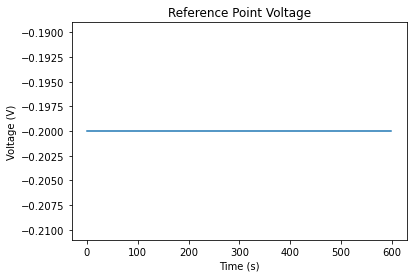

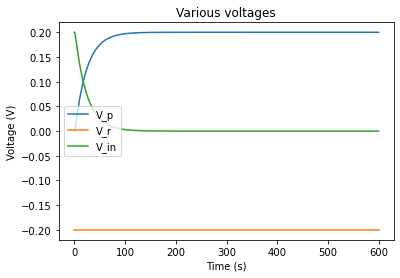

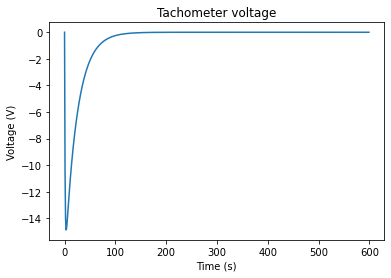

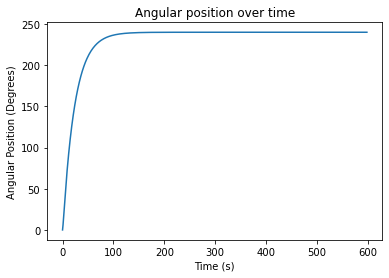

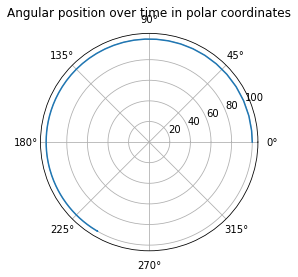

In [61]:
## Initialize storage arrays ##
timeSteps = np.arange(0,tEnd,dt)
V_t = np.zeros(len(timeSteps))
V_in = np.zeros(len(timeSteps))
V_p = np.zeros(len(timeSteps))
theta = np.zeros(len(timeSteps))
gyro_noise = np.random.normal(0,noise_rms,len(timeSteps))

print(np.sqrt(np.mean(gyro_noise**2)))

## Set reference point ##
V_r = np.array([1 if math.floor(0.05 * t) % 2 == 0 else -1 for t in timeSteps])
V_r = -0.2*np.ones(len(timeSteps))
V_r_const = 1

plt.plot(timeSteps, V_r)
plt.title("Reference Point Voltage")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.show()

## Simulate ##
for t in range(len(timeSteps[:-1])):
    
    # Calculate error
    V_in[t] = calculate_V_in(V_r[t], V_p[t], r_1)

    # Calculate tachometer output voltage
    V_t[t] = motorVoltage(k_t,k_m,V_in[t],c,t)

    # Calculate the angular velocity of our servo motor
    dTheta = calculate_dTheta(k_m, V_in[t], c, timeSteps[t]) + gyro_noise[t] + angular_velocity

    # Integrate over the time step to find our new telescope angular position
    if(t == 0):
        theta[t] = 0 + dTheta*dt
    else:
        theta[t] = theta[t-1] + dTheta*dt
        
    # Simulate the potentiometer reading
    V_p[t+1] = calculate_potentiometer_voltage(theta[t],0.3)

## Plot results ##
plt.plot(timeSteps,V_p, label = "V_p")
plt.plot(timeSteps,V_r, label = "V_r")
plt.plot(timeSteps,V_in, label = "V_in")
plt.legend()
plt.title("Various voltages")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.show()

plt.plot(timeSteps,V_t, label = "V_t")
plt.title("Tachometer voltage")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.show()

plt.plot(timeSteps[:-1],theta[:-1], label = "Theta")
plt.title("Angular position over time")
plt.xlabel("Time (s)")
plt.ylabel("Angular Position (Degrees)")
plt.show()

plt.polar(theta[:-1]*np.pi/180, 100*np.ones(len(timeSteps))[:-1])
plt.title("Angular position over time in polar coordinates")
plt.show()